In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from model import GCNN
from dataset import HD5Dataset
import util
import json

In [4]:
# Evaluate the model on the entire dataset
data = HD5Dataset('../data/data_dragon.hd5', seed=42, features=["FirstCharge", "CumulativeCharge", "Time",
            "VertexX", "VertexY", "VertexZ", "RecoX",
"RecoZ", "RecoAzimuth", "RecoZenith"])

Created memory map arrays.


In [10]:
with open('training/hd5-80549/config.json') as f:
    settings = json.load(f)

In [27]:
model = util.model_from_config(settings['model'], 10)

In [33]:
model.load_weights('training/hd5-80549/model_weights.h5')

In [34]:
test_idx = data._get_idx('test')

In [35]:
# Evaluate the model on all the data
batch_size = 128
logits_model = model.predict_generator(data.get_batches(batch_size=batch_size, dataset='test'),
                       steps=int(np.ceil(data.size(dataset='test') / batch_size)))

In [38]:
np.unique(logits_model).shape

(207622,)

In [39]:
y_model = (logits_model >= 0.5).astype(np.int)

In [40]:
y_model = y_model.squeeze()

In [41]:
# Get the pe counts (~charge) of the test data
total_charge = data.file['TotalCharge']['value'][test_idx]

In [42]:
y_gnd = data.targets[test_idx]
y_baseline = (data.delta_loglikelihood[test_idx] >= 2.0).astype(np.uint8)

In [43]:
total_charge_sorted = np.sort(total_charge)

In [44]:
# Find different cutoff values to check performance at different maximal energies by selecting the quantiles of the data
cutoffs = []
quantiles = []
for quantile in np.arange(0.00, 1.0, 0.01):
    quantile = 1.0 - quantile
    quantiles.append(quantile)
    cutoffs.append(total_charge_sorted[int(total_charge.shape[0] * quantile) - 1])

In [45]:
y_model.shape, y_gnd.shape

((220295,), (220295,))

In [46]:
y_model, y_gnd

(array([0, 0, 0, ..., 0, 1, 0]), array([0, 0, 1, ..., 0, 1, 0]))

In [47]:
accuracies = []
for cutoff, quantile in zip(cutoffs, quantiles):
    mask = total_charge <= cutoff
    accuracy_baseline = (y_gnd[mask] == y_baseline[mask]).sum() / mask.sum()
    accuracy_model = (y_model[mask] == y_gnd[mask]).sum() / mask.sum()
    accuracies.append([accuracy_baseline, accuracy_model])
accuracies = np.array(accuracies)

In [48]:
accuracies

array([[0.58990445, 0.57054858],
       [0.58961814, 0.57102507],
       [0.58933526, 0.57150202],
       [0.58893423, 0.57178758],
       [0.58833571, 0.57191831],
       [0.58797783, 0.57210914],
       [0.58759302, 0.57244407],
       [0.58720482, 0.57274227],
       [0.58690686, 0.57300749],
       [0.5865375 , 0.57309396],
       [0.58623055, 0.57317227],
       [0.5859014 , 0.57331864],
       [0.58560603, 0.57353025],
       [0.585163  , 0.5739189 ],
       [0.58481523, 0.5738996 ],
       [0.58443258, 0.57385314],
       [0.58405162, 0.57376234],
       [0.58383103, 0.57383343],
       [0.58341683, 0.57394501],
       [0.58326141, 0.57403692],
       [0.58287183, 0.57425838],
       [0.58266775, 0.5743418 ],
       [0.58238618, 0.57449471],
       [0.5822152 , 0.57466338],
       [0.58202528, 0.57491757],
       [0.58160888, 0.57518112],
       [0.58122416, 0.57555607],
       [0.58120461, 0.57596881],
       [0.58124858, 0.57571937],
       [0.58068538, 0.5759798 ],
       [0.

Text(0, 0.5, 'Accuracy')

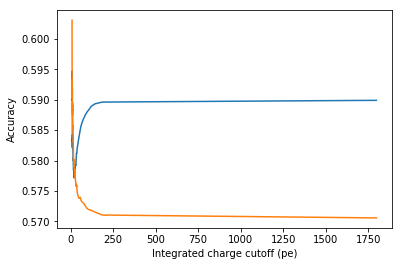

In [49]:
plt.plot(cutoffs, accuracies[:, 0])
plt.plot(cutoffs, accuracies[:, 1])

plt.xlabel('Integrated charge cutoff (pe)')
plt.ylabel('Accuracy')

In [131]:
np.unique(y_model)

array([0])